In [1]:
import random
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from bertopic import BERTopic
from sklearn.feature_extraction.text import TfidfVectorizer

/home/ksg502/miniconda3/envs/humanity/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [32]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [2]:
random.seed(42)

In [3]:
logger = logging.getLogger(__name__)

In [4]:
df_uk = pd.read_csv("../data/processed/UK.csv")
df_us = pd.read_csv("../data/processed/US.csv")
df_me = pd.read_csv("../data/processed/MiddleEast.csv")

In [5]:
df_uk['region'] = 'UK'
df_us['region'] = 'US'
df_me['region'] = 'ME'

In [6]:
all_df = pd.concat([df_uk, df_us, df_me])

In [7]:
all_df['region'].value_counts()

region
US    9982
UK    9116
ME    6369
Name: count, dtype: int64

<Axes: title={'center': 'Top 40 Domains'}, xlabel='source_domain'>

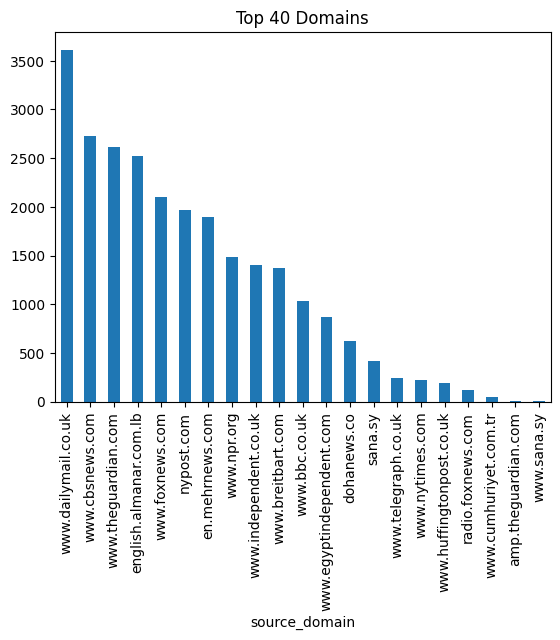

In [8]:
all_df["source_domain"].value_counts()[:40].plot(kind='bar', title="Top 40 Domains")

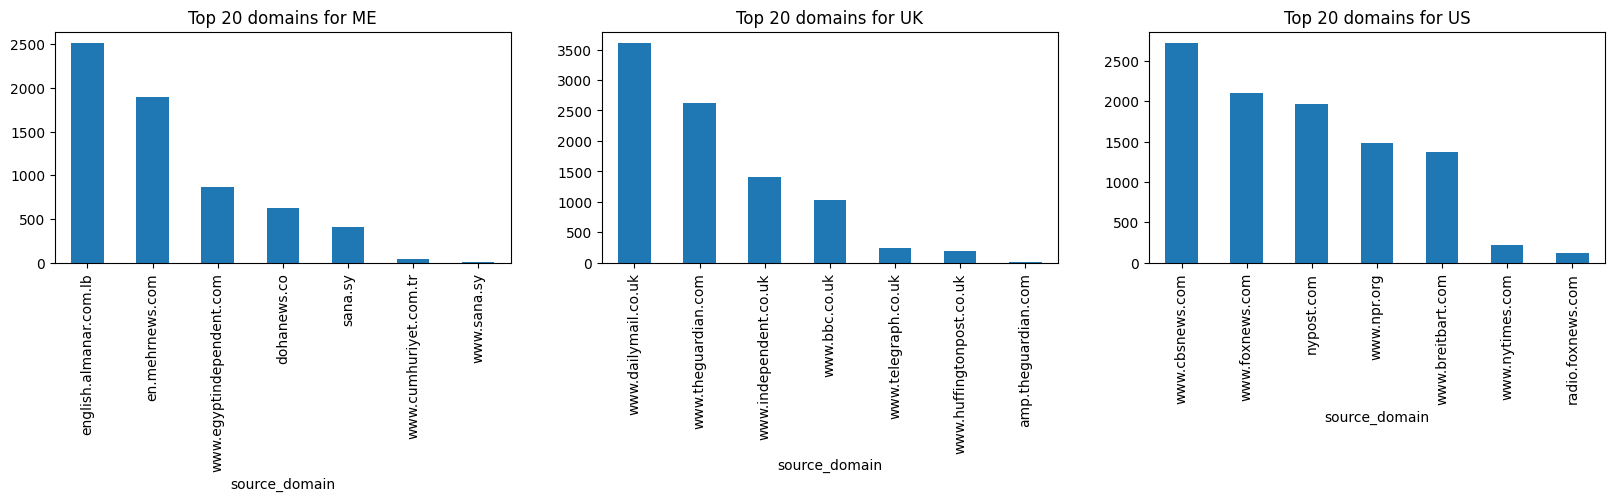

In [9]:
plt.figure(figsize=(20, 3))
for index, (g_name, group) in enumerate(all_df.groupby(by="region")):
    plt.subplot(1, 3, index+1)
    group["source_domain"].value_counts()[:20].plot(kind='bar', title="Top 20 domains for " + g_name)
plt.show()

In [10]:
top_domanis = []
for g_name, group in all_df.groupby(by="region"):
    domains = group["source_domain"].value_counts()[:5]
    top_domanis.extend(list(domains.keys()))
    print(f"Top domains for {g_name}", domains)

Top domains for ME source_domain
english.almanar.com.lb      2519
en.mehrnews.com             1899
www.egyptindependent.com     871
dohanews.co                  622
sana.sy                      412
Name: count, dtype: int64
Top domains for UK source_domain
www.dailymail.co.uk      3615
www.theguardian.com      2619
www.independent.co.uk    1403
www.bbc.co.uk            1029
www.telegraph.co.uk       247
Name: count, dtype: int64
Top domains for US source_domain
www.cbsnews.com      2727
www.foxnews.com      2101
nypost.com           1967
www.npr.org          1486
www.breitbart.com    1367
Name: count, dtype: int64


In [11]:
# all_df = all_df[all_df["source_domain"].isin(top_domanis)]
all_df.dropna(subset=['maintext','title'], inplace=True)

In [12]:
all_df['title_len'] = all_df['title'].apply(lambda x: len(str(x).split(" ")))
all_df['text_len'] = all_df['maintext'].apply(lambda x: len(str(x).split(" ")))

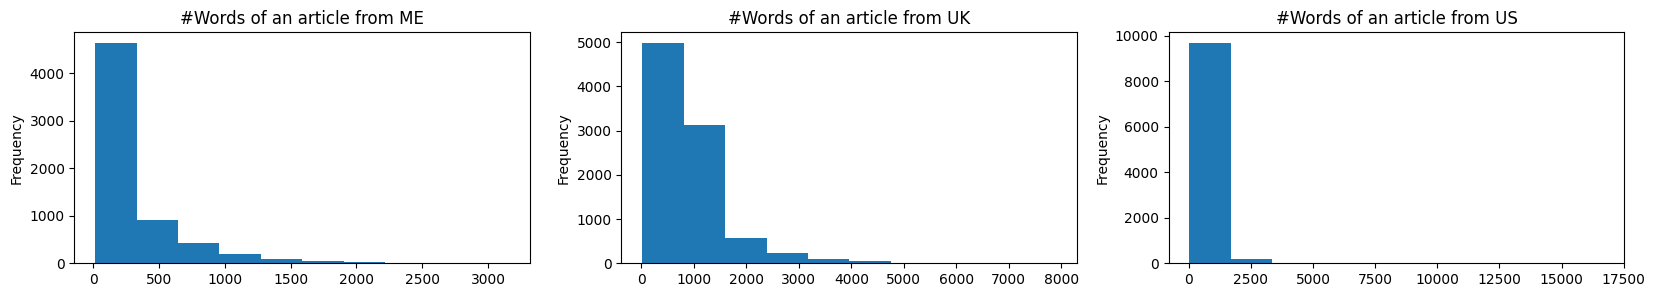

In [13]:
plt.figure(figsize=(20, 3))
for index, (g_name, group) in enumerate(all_df.groupby(by="region")):
    plt.subplot(1, 3, index+1)
    group["text_len"].plot(kind='hist', title="#Words of an article from " + g_name)
plt.show()

In [14]:
q_low = all_df["text_len"].quantile(0.01)
q_hi  = all_df["text_len"].quantile(0.95)

all_df = all_df[(all_df["text_len"] < q_hi) & (all_df["text_len"] > q_low)]

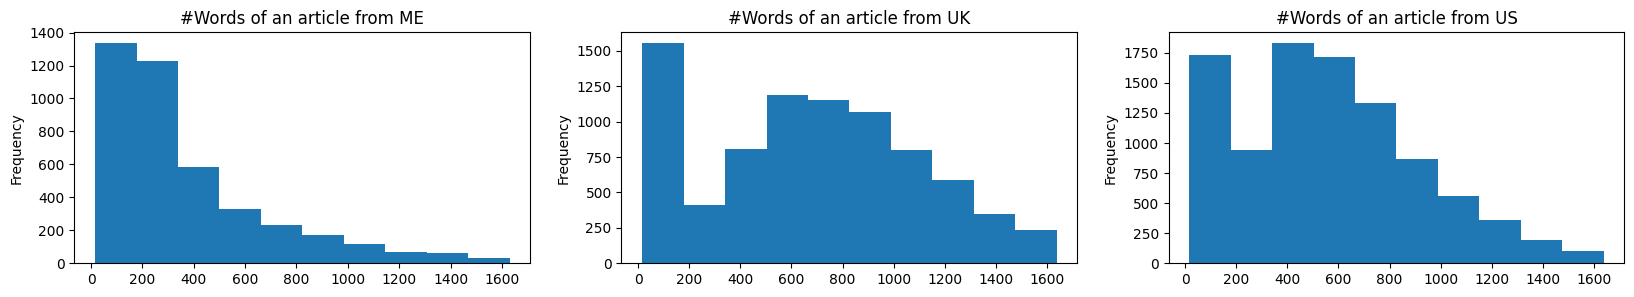

In [15]:
plt.figure(figsize=(20, 3))
for index, (g_name, group) in enumerate(all_df.groupby(by="region")):
    plt.subplot(1, 3, index+1)
    group["text_len"].plot(kind='hist', title="#Words of an article from " + g_name)
plt.show()

In [16]:
all_df.region.value_counts()

region
US    9629
UK    8150
ME    4146
Name: count, dtype: int64

In [21]:
all_df.columns

Index(['description', 'maintext', 'source_domain', 'title', 'url', 'language',
       'date_publish', 'region', 'title_len', 'text_len'],
      dtype='object')

In [29]:
for g_name, group in all_df.groupby(by="region"):
    group.to_csv(f"../data/processed/selected_{g_name}.csv", index=False)

In [17]:
all_df.to_csv("../data/processed/selected_data.csv", index=False)

In [20]:
len(all_df.source_domain.value_counts())

21

In [25]:
lens = 0
sampled_df = pd.DataFrame()
for g_name, group in all_df.groupby(by="source_domain"):
    if len(group) > 100:
        group = group.sample(100)
    sampled_df = pd.concat([sampled_df, group])
    lens += len(group)
print(lens)

1811


In [27]:
sampled_df.source_domain.value_counts()

source_domain
dohanews.co                 100
english.almanar.com.lb      100
en.mehrnews.com             100
nypost.com                  100
radio.foxnews.com           100
www.nytimes.com             100
sana.sy                     100
www.bbc.co.uk               100
www.breitbart.com           100
www.cbsnews.com             100
www.dailymail.co.uk         100
www.egyptindependent.com    100
www.foxnews.com             100
www.theguardian.com         100
www.huffingtonpost.co.uk    100
www.independent.co.uk       100
www.npr.org                 100
www.telegraph.co.uk         100
amp.theguardian.com           8
www.cumhuriyet.com.tr         2
www.sana.sy                   1
Name: count, dtype: int64

In [28]:
sampled_df.to_csv("../data/processed/selected_data_100sampled", index=False)

In [30]:
titles = all_df.title.values
texts = all_df.maintext.values

In [31]:
tfidf = TfidfVectorizer(min_df=2, stop_words='english')
tf_idf_words = tfidf.fit_transform(all_df['title'])
tf_idf_feature_array = np.array(tfidf.get_feature_names_out())
tfidf_sorting = np.argsort(tf_idf_words.toarray()).flatten()[::-1]
n = 30
top_n = tf_idf_feature_array[tfidf_sorting][:n]
top_n

array(['slam', 'veto', 'resolution', 'palestinians', 'ceasefire', 'gaza',
       'exporting', 'export', 'explosives', 'explosive', 'explosions',
       'explosion', 'explore', 'exploiting', 'exports', 'exploding',
       'explodes', 'exploded', 'explode', 'explains', 'explained',
       'explain', 'exploit', 'extra', 'extinction', 'extent', 'extensive',
       'extensions', 'extension', 'extends'], dtype=object)

In [33]:
topic_model = BERTopic(language="english", min_topic_size=50)
topics, probs = topic_model.fit_transform(titles)

In [34]:
topic_model.get_topic_info().to_csv("../data/outputs/topics.csv", index=False)

In [43]:
topic_map = dict(topic_model.get_topic_info()[['Topic','Name']].set_index('Topic')['Name'])

In [44]:
topic_map

{-1: '-1_in_to_of_gaza',
 0: '0_hostages_hostage_hamas_release',
 1: '1_labour_starmer_sunak_keir',
 2: '2_antisemitism_students_campus_university',
 3: '3_us_syria_iraq_iran',
 4: '4_ukraine_aid_bill_senate',
 5: '5_photos_she_the_her',
 6: '6_hospital_hospitals_alshifa_gazas',
 7: '7_biden_joe_bidens_trump',
 8: '8_qatar_qatars_egypt_sisi',
 9: '9_biden_solution_twostate_bidens',
 10: '10_hamas_israelhamas_war_israel',
 11: '11_crimes_genocide_court_zionists',
 12: '12_border_senate_bill_deal',
 13: '13_netanyahu_benjamin_netanyahus_rejects',
 14: '14_journalists_jazeera_al_journalist',
 15: '15_graffiti_jewish_antisemitic_woman',
 16: '16_protesters_propalestinian_bridge_block',
 17: '17_children_family_gaza_relatives',
 18: '18_rafah_crossing_offensive_egypt',
 19: '19_haley_debate_desantis_nikki',
 20: '20_blinken_antony_middle_east',
 21: '21_claudine_gay_harvard_president',
 22: '22_aid_humanitarian_un_gaza',
 23: '23_gaza_war_israels_israelgaza',
 24: '24_truce_ceasefire_extend

In [36]:
all_df['topic'] = topics
all_df['topic_name'] = 

In [37]:
all_df.groupby(by="region")['topic'].value_counts()[:3]

region  topic
ME      -1       1474
         8        370
         3        316
Name: count, dtype: int64

In [24]:
topic_model.visualize_documents(titles, topics)

In [40]:
selected_topics = [-1,0]

In [42]:
all_df = all_df[all_df['topic'].isin(selected_topics)]

In [43]:
all_df

,description,maintext,source_domain,title,url,language,date_publish,region,title_len,text_len,topic
0,The strategy goes well beyond defeating an opp...,How to make sense of the sheer intensity of Is...,www.theguardian.com,Israel’s use of disproportionate force is a lo...,https://www.theguardian.com/commentisfree/2023...,en,2023-12-05 12:47:14,UK,14,969,0
2,"Mexico has launched its army-run airline, with...",For free real time breaking news alerts sent s...,www.independent.co.uk,"Mexico's army-run airline takes to the skies, ...",https://www.independent.co.uk/news/andres-manu...,en,2023-12-26 17:08:10,UK,15,761,0
4,Palestinian Islamic Jihad posts videos of two ...,The BBC will not be broadcasting the clip itse...,www.bbc.co.uk,Israel sees 'sign of life' in Gaza hostage video,https://www.bbc.co.uk/news/world-middle-east-6...,en,2023-11-09 18:57:24,UK,9,41,0
6,The attack was in retaliation for ballistic mi...,The United States on Tuesday launched a series...,www.dailymail.co.uk,US launches airstrikes on Iran-backed terroris...,https://www.dailymail.co.uk/news/article-12998...,en,2024-01-23 21:54:22,UK,19,646,0
8,Residents of Jenin say Israeli army seems inte...,Fluffy pink slippers on her feet and scarves t...,www.theguardian.com,‘Israel only responds to force’: support for H...,https://www.theguardian.com/world/2023/dec/16/...,en,2023-12-16 18:23:29,UK,15,1093,0
...,...,...,...,...,...,...,...,...,...,...,...
7704,French and German foreign ministries criticize...,French and German foreign ministries criticize...,www.dailysabah.com,"France, Germany slam Israeli proposal to expel...",https://www.dailysabah.com/world/europe/france...,en,2024-01-03 19:50:00,ME,9,367,0
7708,TEHRAN (Tasnim) – The Iranian UN ambassador sl...,In a letter to President of the UN Security Co...,www.tasnimnews.com,UN Envoy Affirms Iran’s Right to Respond to Is...,https://www.tasnimnews.com/en/news/2024/01/03/...,en,2024-01-03 06:27:47,ME,10,732,0
7712,TEHRAN (Tasnim) – The foreign minister of Iran...,In a letter to Secretary General of the D-8 Is...,www.tasnimnews.com,Iran Praises D-8’s Support for Palestine,https://www.tasnimnews.com/en/news/2023/12/11/...,en,2023-12-11 06:31:13,ME,6,128,0
7713,The northern Gaza were left without a function...,Northern Gaza left without functional hospital...,www.hurriyetdailynews.com,Northern Gaza left without functional hospital...,https://www.hurriyetdailynews.com/northern-gaz...,en,2023-12-21 15:28:42,ME,7,482,0


In [44]:
all_df.to_csv("../data/processed/selected_data.csv", index=False)

In [45]:
topic_model = BERTopic(language="english", min_topic_size=20)
topics, probs = topic_model.fit_transform(all_df['maintext'])

In [46]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1393,-1_the_of_in_and,"[the, of, in, and, to, that, on, said, for, gaza]","[Israel is engaged in a “multi-front war”, its..."
1,0,260,0_the_of_and_regime,"[the, of, and, regime, zionist, in, to, iran, ...",[Nasser Kan'ani made the remarks while speakin...
2,1,248,1_hostages_hamas_the_of,"[hostages, hamas, the, of, to, and, in, was, r...",[Israel approves Hamas hostage deal Israeli go...
3,2,235,2_trkiye_erdoan_the_to,"[trkiye, erdoan, the, to, and, in, of, for, tu...",[Speaking to reporters as he returned from Qat...
4,3,178,3_gaza_the_in_israeli,"[gaza, the, in, israeli, of, killed, and, to, ...","[In a heinous Israeli massacre, dozens of Pale..."
5,4,160,4_the_cup_in_team,"[the, cup, in, team, to, football, match, will...",[Who will Scotland be drawn with in Hamburg?\n...
6,5,133,5_hezbollah_lebanon_the_in,"[hezbollah, lebanon, the, in, of, lebanese, is...",[Israel is planning to invade Lebanon to push ...
7,6,133,6_court_genocide_south_the,"[court, genocide, south, the, case, africa, is...",[What is South Africa’s genocide case against ...
8,7,132,7_hospital_the_alshifa_to,"[hospital, the, alshifa, to, hamas, and, hospi...",[Hundreds of Palestinians flee Al-Shifa hospit...
9,8,93,8_we_moon_my_me,"[we, moon, my, me, and, she, was, to, they, is]","[A Belfast-born man who lost his wife, his mot..."
